# Exotic Models Notebook
#### David W. Barker

### Purpose
Intended for all the code and figures needed for my first paper on exotic physic models and how they may effect the 21 cm signal and what kind of signal extraction will be required to robustly extract said signal...wow that is wordy, but it's okay for now.

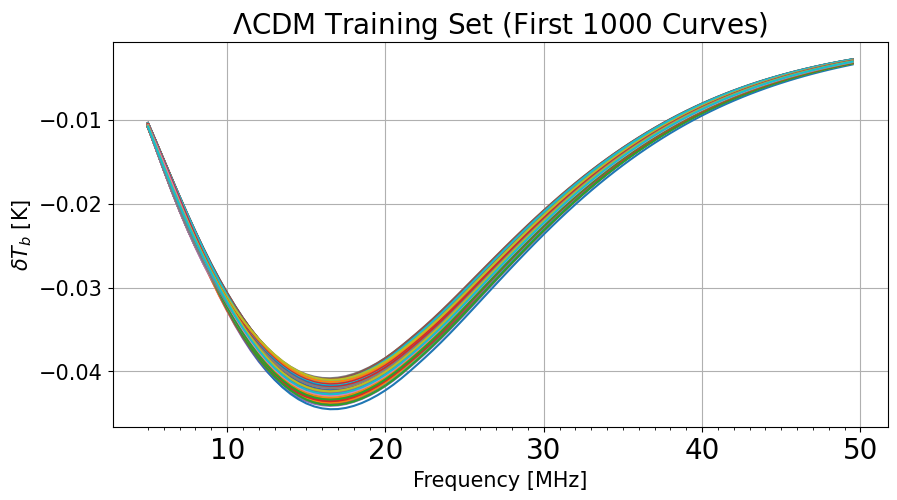

In [41]:
### Boilerplate ###
## Boiler Plate that is required to run to make any cell below this work ##
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/dbarker7752/py21cmsig")
import py21cmsig
from pylinex import BasisSum, MetaFitter, AttributeQuantity, TrainedBasis, RepeatExpander, NullExpander, Forecaster, CompiledQuantity
from tqdm import tqdm
import healpy as hp
from scipy import stats
from scipy.optimize import fsolve
from importlib import reload
import scipy
import perses
import copy
import os
import lmfit
from astropy.io import fits
from lmfit import Minimizer, Parameters, create_params, report_fit
import lochness
import perses.models
import camb

# universal variables
frequencies = np.arange(5,50,0.5)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today
f_He = 0.08    # Fraction of Helium by number
y_P = 0.2454  # Fraction of helium by mass (from Planck VI 2018) 
p_crit = 1.88e-29*h**2  # [g / cm^3] The critical density of the universe
m_p = 1.6727e-24   #[g]  mass of a proton
m_pMev = 938.28   # [MeV/c^2] mass of a proton
m_e = 9.1094e-28   #[g]  mass of an electron
m_eMev = 0.511      # [Mev/c^2] mass of an electron
m_He = 6.644e-24   # [g] mass of helium
fsc = 1/137        # dimensionless fine structure constant
z_array = np.arange(20,1100)
#n_b0 = 2.06e-7   #[baryons per cubic centimeter] Old version from Joshua's comps paper that isn't a function of Omega baryons
n_b0 = (1-y_P)*omB0*p_crit/m_p+y_P*omB0*p_crit/m_He  # number density of baryons (by definition doesn't include electrons)
T_gamma0 = 2.725   # [Kelvin] modern CMB temperature
T_star = 0.068    # [Kelvin] the temperature equivalent of the energy difference of the 21 cm hyperfine spin states
A_10 = 2.85e-15    # [inverse seconds] Einstein coefficient for the spontaneous emission of the hyperfine spin states
# Less neccesary (or at least less understood by me but needed by some code)
As = 2.099e-9  # Amplitude of a power spectrum of adiabatic perturbations
ns = 0.9649    # Spectra index of a power spectrum of adiabatic perturbations

### Common equations:
H = lambda z,omR0,omM0,omK0,omL0: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Standard Lambda CDM hubble flow in inverse seconds

# x_e using camb
parameters_camb = camb.set_params(H0=H0, ombh2=omB0*h**2, omch2=omC0*h**2, As=As, ns=ns)
camb_data= camb.get_background(parameters_camb)
camb_xe = camb_data.get_background_redshift_evolution(z_array, ["x_e"], format="array")
# or if you want an interpolated version:
camb_xe_interp = scipy.interpolate.CubicSpline(z_array,camb_xe.flatten())  # Needs a redshift argument

## n_H and n_e

n_H = lambda z,x_e: n_b0*(1+z)**3*(1-x_e(z))
n_e = lambda z,x_e: n_b0*(1+z)**3*(x_e(z))

# example simulation with fiducial signal
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/example_simulated_data_fiducial","r")
sim_data = np.array(hdf5["simulation"])
sim_data_signal = np.array(hdf5["signal"])
sim_data_no_noise = np.array(hdf5["simulation_no_noise"])
sim_data_noise_function = np.array(hdf5["noise_function"])

# radiometer noise
sigT = lambda T_b, N, dnu, dt: T_b/(N*(np.sqrt(dnu*dt)))
N_antenna = 2
dnu = 1e6
dt = 10000*3600
noise_level = sigT(sim_data,N_antenna,dnu,dt)

# 10 LSTs for 32 bit map
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/master_foreground_array_32bit_10LSTs","r")
master_foreground_array = np.array(f["sky_maps"])

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/labmda_CDM_training_set_10k","r")
lambdaCDM_training_set = np.array(f["curves"])
lambdaCDM_training_set_params = np.array(f["parameters"])

# This is a boiler plate plot with all the good options figured out
plt.figure(figsize=(10, 5))

for n in np.arange(1000):
    plt.plot(frequencies,lambdaCDM_training_set[n][16::2])   #### Need to change 4 back to 16 if not using 50 frequency bins ####
plt.xticks(ticks=np.arange(5,51,1),minor=True)
plt.xticks(size=20)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r"$\delta T_b$ [K]",fontsize=15)
plt.title(r"$\Lambda$CDM Training Set (First 1000 Curves)", fontsize=20)
plt.grid()

### Task: See if the Forecaster is worth swapping out with fitter.

In [ ]:
# This is a test cell block that is me just getting to know the forecaster class

## This part of the cell block creates the 10 LST simulation and training set to test the forecaster ##

# varied regolith raw (from Fatima)
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Training Sets 10LST for Varied Regolith  # parameters are all the same as varied regolith training set raw params
varied_regolith_TS_raw_10LSTs = np.zeros((10,221,50))
f1 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_TS_raw_10LSTs[0] = f1["Foreground_Training_Set"][:,0,:]
f2 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_2","r")
varied_regolith_TS_raw_10LSTs[1] = f2["Foreground_Training_Set"][:,0,:]
f3 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_3","r")
varied_regolith_TS_raw_10LSTs[2] = f3["Foreground_Training_Set"][:,0,:]
f4 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_4","r")
varied_regolith_TS_raw_10LSTs[3] = f4["Foreground_Training_Set"][:,0,:]
f5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_5","r")
varied_regolith_TS_raw_10LSTs[4] = f5["Foreground_Training_Set"][:,0,:]
f6 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_6","r")
varied_regolith_TS_raw_10LSTs[5] = f6["Foreground_Training_Set"][:,0,:]
f7 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_7","r")
varied_regolith_TS_raw_10LSTs[6] = f7["Foreground_Training_Set"][:,0,:]
f8 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_8","r")
varied_regolith_TS_raw_10LSTs[7] = f8["Foreground_Training_Set"][:,0,:]
f9 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_9","r")
varied_regolith_TS_raw_10LSTs[8] = f9["Foreground_Training_Set"][:,0,:]
f10 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_10","r")
varied_regolith_TS_raw_10LSTs[9] = f10["Foreground_Training_Set"]

# varied regolith beam maps (all sky and normalized)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/normalized_beams_varied_regolith","r")
beams = hdf5["beams"]
beam_parameters = hdf5["parameters"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]

# fiducial signal
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
# fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.25),parameter_array,1)[0][0][16:]
fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.5),parameter_array,1)[0][0][8:] 

# Monochromatic Gaussian Beams Observations for 10 LSTs
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_10LSTs = np.zeros((10,len(varied_regolith_training_set_raw),len(frequencies)))
for l in range(10):
    for n in range(len(varied_regolith_training_set_raw)):
        beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_TS_raw_10LSTs[l][n])
        varied_regolith_training_set_10LSTs[l][n] = beam_regolith_interp(frequencies)

## The rest of this code block creates 10 LST training sets        
foreground_example_1_10LSTs = np.zeros((10,len(frequencies)))
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
for l in range(10):
    beam_parameters = np.zeros((3,2))
    percent_range = 0.0000000000000001
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8

    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    N=1
    Nb=0
    Nf=0
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    foreground_parameters = np.array([0,0,0])
    parameter_mean = None
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)


    foreground_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf, B_values_given=False)
    foreground_example_1_10LSTs[l] = foreground_element[0][0]

# Example of not having enough curves
simple_Fatima_sim=py21cmsig.multi_spectra_simulation_run(frequencies,foreground_example_1_10LSTs,fiducial_signal,N_antenna,dnu,dt)
beam_parameters = np.zeros((3,2))
percent_range = 0.025
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
N_raw=1000000
N = 100000
N_samp = int(np.sqrt(N_raw))**2
Nb=0
Nf=0


test_case_10LSTs_raw = np.zeros((N_samp,10,len(frequencies)))
for l in range(10):
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8


    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    foreground_parameters = [0.05*percent_range,0.025*percent_range,0.05*percent_range]
    # parameter_mean =  true_parameters[0:3]
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    raw_beam_weighted_sky_maps = raw_sky_maps
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    data=simple_Fatima_sim[0]
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)
    test_case_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N_raw,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf,B_values_given=False)
    test_case_10LSTs_raw[:,l,:] = test_case_element[0]
    

np.random.shuffle(test_case_10LSTs_raw)
test_case_10LSTs = test_case_10LSTs_raw[0:N]

## End of the section that creates the training set and input signal ##


100%|██████████| 90/90 [00:00<00:00, 214.61it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 203.70it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3647.22it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 207.25it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 6150.01it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 215.23it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2474.52it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 213.91it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 5518.82it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 209.93it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2181.13it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 216.19it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2659.67it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 212.13it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3241.35it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 224.79it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 215.13it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 174.42it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 116.75it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 178.86it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 112.57it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 189.53it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 122.30it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 186.73it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 120.26it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 198.80it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 120.50it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 190.09it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 119.99it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 190.65it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 117.60it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 185.78it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 123.29it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 207.65it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 121.60it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 204.44it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 120.06it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]
/home/dbarker7752/21_cm_group/SVD_Analysis_Data already exists. Will perform analysis using existing file. If you wish to rerun, move or delete existing file.


In [106]:
## Now begins the section dedicated to creating a Forecaster object ##

n_LSTs = len(simple_Fatima_sim[5])     # the number of correlated spectra (number of LSTs in most cases)
file_name = "/home/dbarker7752/21_cm_group/SVD_Analysis_Data/pylinex_forecaster_test"
num_curves_to_create = 100
error = simple_Fatima_sim[5].flatten()  # flattens the 10 LST error to match the input required for pylinex
names = ["systematics","signal"] 
training_sets =  [np.reshape(test_case_10LSTs, (len(test_case_10LSTs), -1)), lambdaCDM_training_set[:,16::2]]  # flattens the 10 LST training set to make it work for the required pylinex input
input_curve_sets = None    # None means it will randomly pull from the training set for the input signal. Later you should actually set what each test is.
dimensions = [{'systematics' : np.arange(1,500)}, {'signal' : np.arange(1,10)}]
compiled_quantity = CompiledQuantity('compiled', AttributeQuantity('BPIC'))    # replace 'BPIC' with "DIC" or "BIC" for different term selection criteria
quantity_to_minimize = "BPIC"
expanders = [NullExpander(),RepeatExpander(n_LSTs)]
num_curves_to_score = 0
use_priors_in_fit = False
prior_covariance_diagonal = False
seed = 12345
target_subbasis_name = "signal"
verbose= True
Forecaster_test = Forecaster(file_name,num_curves_to_create,error,names,training_sets,input_curve_sets,dimensions,compiled_quantity, quantity_to_minimize,\
                             expanders, num_curves_to_score=num_curves_to_score, use_priors_in_fit=use_priors_in_fit,\
                             prior_covariance_diagonal=prior_covariance_diagonal, seed = seed, target_subbasis_name=target_subbasis_name, verbose=verbose)

Minimizing BPIC over grid.
Minimizing subbasis_bias_statistic over grid.


In [97]:
# Loads up the pylinex foreground test hdf5 file
pylinex_Forecaster_test = h5py.File(file_name,"r")
pylinex_Forecaster_test.keys()

<KeysViewHDF5 ['data', 'error', 'expanders', 'input_curves', 'meta_fitter', 'names']>

In [104]:
pylinex_Forecaster_test["meta_fitter"]

<HDF5 group "/meta_fitter" (5 members)>

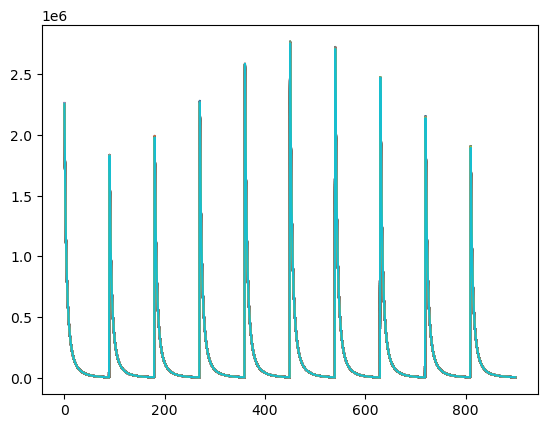

In [102]:
for n in range(100):
    plt.plot(pylinex_Forecaster_test["meta_fitter"]["data"][n])

### Task: Compare Numerically Derived Error with Analytical Pylinex Error.
Conclusion: They seem to be pretty much the same. At least when you fix the terms. That is something pylinex error couldn't possibly account for is the difference in terms based on the different noise realizations.

100%|██████████| 90/90 [00:00<00:00, 205.10it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3512.82it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 212.31it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 5555.37it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 212.68it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 4433.73it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 222.36it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3440.77it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 213.14it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2467.24it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 211.23it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2807.43it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 207.19it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2657.99it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 165.61it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 7133.17it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 198.65it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2535.85it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 209.50it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2551.28it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 203.34it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 118.64it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 194.44it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:07<00:00, 125.96it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 199.52it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 118.65it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 194.72it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 116.28it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 206.59it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 119.29it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 222.65it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 124.26it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 188.06it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 123.59it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 207.77it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 124.49it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 203.24it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 121.45it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 211.37it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:07<00:00, 125.73it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 100/100 [19:55<00:00, 11.96s/it]


Maximum bias of the systematics rms is 8.19199308104194
Maximum bias of the signal rms is 8.203649878360034
Average number of systematics terms used for fit: 218.67
Average number of signal terms used for fit: 1.03
Reduced Chi Squared of mean fit: [1.11874758]
Mean Reduced Chi Squared: 1.0673085858980835
STD of Reduced Chi Squared Distribution: 0.05676712877453783
RMS between mean fit and input: 0.02907192505214578


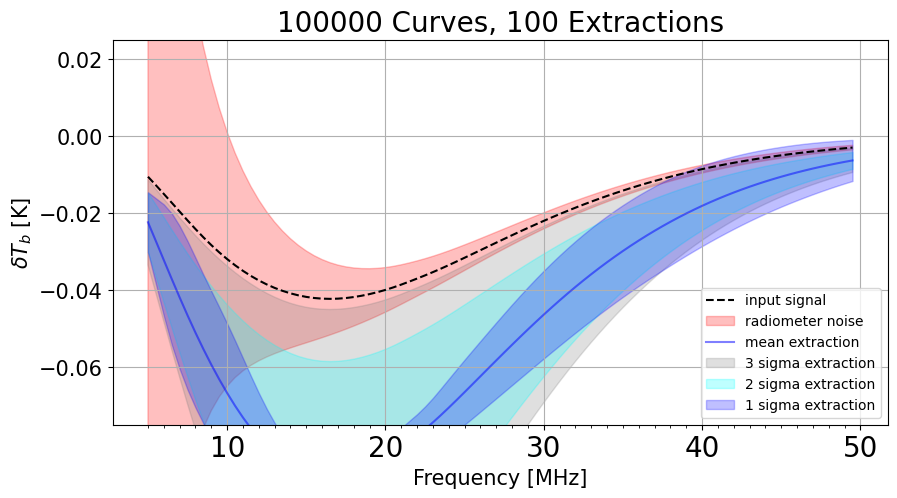

In [ ]:
### This cell get us our numerically derived error (with unfixed terms) ###


# varied regolith raw (from Fatima)
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Training Sets 10LST for Varied Regolith  # parameters are all the same as varied regolith training set raw params
varied_regolith_TS_raw_10LSTs = np.zeros((10,221,50))
f1 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_TS_raw_10LSTs[0] = f1["Foreground_Training_Set"][:,0,:]
f2 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_2","r")
varied_regolith_TS_raw_10LSTs[1] = f2["Foreground_Training_Set"][:,0,:]
f3 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_3","r")
varied_regolith_TS_raw_10LSTs[2] = f3["Foreground_Training_Set"][:,0,:]
f4 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_4","r")
varied_regolith_TS_raw_10LSTs[3] = f4["Foreground_Training_Set"][:,0,:]
f5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_5","r")
varied_regolith_TS_raw_10LSTs[4] = f5["Foreground_Training_Set"][:,0,:]
f6 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_6","r")
varied_regolith_TS_raw_10LSTs[5] = f6["Foreground_Training_Set"][:,0,:]
f7 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_7","r")
varied_regolith_TS_raw_10LSTs[6] = f7["Foreground_Training_Set"][:,0,:]
f8 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_8","r")
varied_regolith_TS_raw_10LSTs[7] = f8["Foreground_Training_Set"][:,0,:]
f9 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_9","r")
varied_regolith_TS_raw_10LSTs[8] = f9["Foreground_Training_Set"][:,0,:]
f10 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_10","r")
varied_regolith_TS_raw_10LSTs[9] = f10["Foreground_Training_Set"]

# varied regolith beam maps (all sky and normalized)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/normalized_beams_varied_regolith","r")
beams = hdf5["beams"]
beam_parameters = hdf5["parameters"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]

# fiducial signal
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
# fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.25),parameter_array,1)[0][0][16:]
fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.5),parameter_array,1)[0][0][8:] 

# Monochromatic Gaussian Beams Observations for 10 LSTs
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_10LSTs = np.zeros((10,len(varied_regolith_training_set_raw),len(frequencies)))
for l in range(10):
    for n in range(len(varied_regolith_training_set_raw)):
        beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_TS_raw_10LSTs[l][n])
        varied_regolith_training_set_10LSTs[l][n] = beam_regolith_interp(frequencies)

## The rest of this code block creates 10 LST training sets        
foreground_example_1_10LSTs = np.zeros((10,len(frequencies)))
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
for l in range(10):
    beam_parameters = np.zeros((3,2))
    percent_range = 0.0000000000000001
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8

    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    N=1
    Nb=0
    Nf=0
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    foreground_parameters = np.array([0,0,0])
    parameter_mean = None
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)


    foreground_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf, B_values_given=False)
    foreground_example_1_10LSTs[l] = foreground_element[0][0]

# Example of not having enough curves
simple_Fatima_sim=py21cmsig.multi_spectra_simulation_run(frequencies,foreground_example_1_10LSTs,fiducial_signal,N_antenna,dnu,dt)
beam_parameters = np.zeros((3,2))
percent_range = 0.025
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
N_raw=1000000
N = 100000
N_samp = int(np.sqrt(N_raw))**2
Nb=0
Nf=0


test_case_10LSTs_raw = np.zeros((N_samp,10,len(frequencies)))
for l in range(10):
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8


    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    foreground_parameters = [0.05*percent_range,0.025*percent_range,0.05*percent_range]
    # parameter_mean =  true_parameters[0:3]
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    raw_beam_weighted_sky_maps = raw_sky_maps
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    data=simple_Fatima_sim[0]
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)
    test_case_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N_raw,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf,B_values_given=False)
    test_case_10LSTs_raw[:,l,:] = test_case_element[0]
    

np.random.shuffle(test_case_10LSTs_raw)
test_case_10LSTs = test_case_10LSTs_raw[0:N]

n_samples_ts_test = 5
n_samples_rn_test = 100
restrict_runs = 0
num_basis_vectors = 1000
num_divisions = 10   
num_sig_vectors = 5
num_sys_vectors = 500
man_sys_terms = 0
man_sig_terms = 0
# tss_Fatima_simp = py21cmsig.extraction_statistics(n_samples_ts_test,test_case_10LSTs,lambdaCDM_training_set[:,16::2],simple_Fatima_sim[0],simple_Fatima_sim[5],simple_Fatima_sim[1],simple_Fatima_sim[2],frequency_array = frequencies,\
#                 num_sig_vectors=num_sig_vectors,num_sys_vectors=num_sys_vectors,IC="BIC",ignore_IC=False, man_sys_terms=man_sys_terms,\
#                     man_sig_terms=man_sig_terms,title=f"{N} Curves,",use_fit_noise=False,training_set_to_test="systematics",test_mode="training set size",\
#                         restrict_runs=0,display_type="cumulative sigmas",priors=False,multi_spectra=True,num_basis_vectors=num_basis_vectors, ylim=(-0.075,0.025))

rn_Fatima_simp1_vhc = py21cmsig.extraction_statistics(n_samples_rn_test,test_case_10LSTs,lambdaCDM_training_set[:,16::2],simple_Fatima_sim[0],simple_Fatima_sim[5],simple_Fatima_sim[1],simple_Fatima_sim[2],frequency_array = frequencies,\
                num_sig_vectors=num_sig_vectors,num_sys_vectors=num_sys_vectors,IC="BIC",ignore_IC=False, man_sys_terms=man_sys_terms,\
                    man_sig_terms=man_sig_terms,title=f"{N} Curves,",use_fit_noise=False,training_set_to_test="systematics",test_mode="random noise",\
                        restrict_runs=0,display_type="cumulative sigmas",priors=False,multi_spectra=True,num_basis_vectors=num_basis_vectors, ylim=(-0.075,0.025))

print(f"RMS between mean fit and input: {np.sqrt(((rn_Fatima_simp1_vhc[1] - fiducial_signal)**2).mean())}")

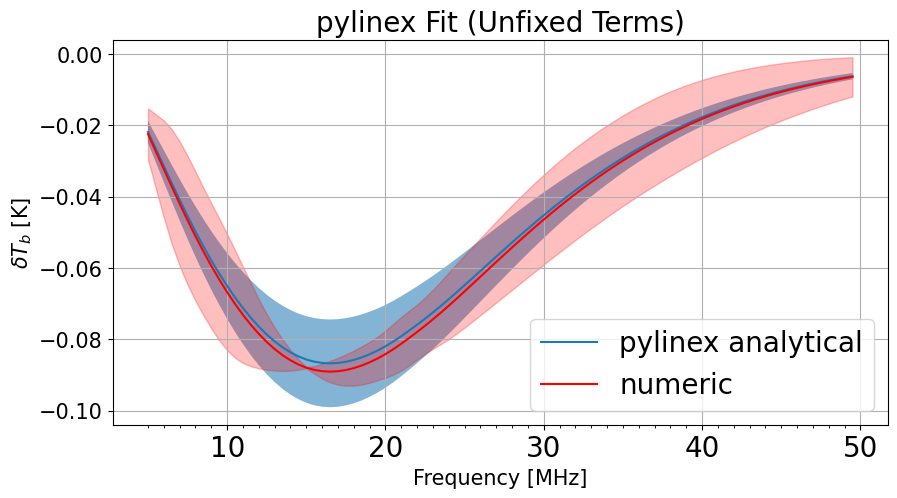

In [48]:
### This cell now plots the one sigma error of the analytical pylinex error ###
mean = rn_Fatima_simp1_vhc[11][0].subbasis_channel_mean("signal")  # values that define the mean of the fit.
error = rn_Fatima_simp1_vhc[11][0].subbasis_channel_error("signal")
mean_numeric = rn_Fatima_simp1_vhc[1]
sigma1 = rn_Fatima_simp1_vhc[2]
error_numeric = np.abs(sigma1-mean)
# This is a boiler plate plot with all the good options figured out
plt.figure(figsize=(10, 5))


plt.plot(frequencies,mean, label="pylinex analytical")
plt.plot(frequencies,mean_numeric, color = "red", label = "numeric")
plt.fill_between(frequencies, mean+error, mean-error,alpha=0.55)
plt.fill_between(frequencies, mean_numeric+error_numeric, mean_numeric-error_numeric,alpha=0.25, color="red") 
plt.xticks(ticks=np.arange(5,51,1),minor=True)
plt.xticks(size=20)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r"$\delta T_b$ [K]",fontsize=15)
plt.title(r"pylinex Fit (Unfixed Terms)", fontsize=20)
plt.legend(fontsize=20)
plt.grid()

100%|██████████| 90/90 [00:00<00:00, 219.52it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 1957.21it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 220.48it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 204.44it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 7958.83it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 189.94it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2057.04it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 153.10it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 2962.08it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 208.08it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 218.58it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 4832.15it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 206.76it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 213.23it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 5121.25it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 216.88it/s]


[[2.7831 2.7831]
 [3.7982 3.7982]
 [4.1932 4.1932]]


100%|██████████| 1/1 [00:00<00:00, 1455.34it/s]


[0 0 0]


100%|██████████| 90/90 [00:00<00:00, 201.58it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:13<00:00, 74.70it/s] 


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 207.67it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 124.81it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 214.33it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 120.01it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 215.91it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:09<00:00, 107.07it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 208.62it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 122.00it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 206.32it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 122.84it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 208.88it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 117.68it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 200.43it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 117.66it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 199.05it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 118.28it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 90/90 [00:00<00:00, 196.86it/s]


[[2.7135225 2.8526775]
 [3.703245  3.893155 ]
 [4.08837   4.29803  ]]


100%|██████████| 1000/1000 [00:08<00:00, 122.22it/s]


[0.0012500000000000002, 0.0006250000000000001, 0.0012500000000000002]


100%|██████████| 100/100 [08:33<00:00,  5.14s/it]


Maximum bias of the systematics rms is 3.61538216472951
Maximum bias of the signal rms is 3.709934061893219
Average number of systematics terms used for fit: 229.0
Average number of signal terms used for fit: 1.0
Reduced Chi Squared of mean fit: [1.08185782]
Mean Reduced Chi Squared: 1.0752733817087394
STD of Reduced Chi Squared Distribution: 0.05555371565567594


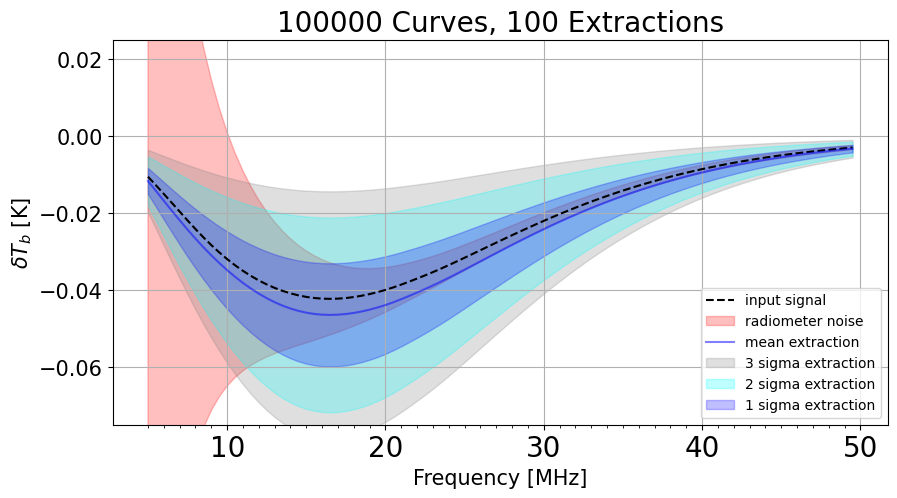

In [2]:
### This cell get us our numerically derived error (with fixed terms) ###


# varied regolith raw (from Fatima)
f = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Training Sets 10LST for Varied Regolith  # parameters are all the same as varied regolith training set raw params
varied_regolith_TS_raw_10LSTs = np.zeros((10,221,50))
f1 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set","r")
varied_regolith_TS_raw_10LSTs[0] = f1["Foreground_Training_Set"][:,0,:]
f2 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_2","r")
varied_regolith_TS_raw_10LSTs[1] = f2["Foreground_Training_Set"][:,0,:]
f3 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_3","r")
varied_regolith_TS_raw_10LSTs[2] = f3["Foreground_Training_Set"][:,0,:]
f4 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_4","r")
varied_regolith_TS_raw_10LSTs[3] = f4["Foreground_Training_Set"][:,0,:]
f5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_5","r")
varied_regolith_TS_raw_10LSTs[4] = f5["Foreground_Training_Set"][:,0,:]
f6 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_6","r")
varied_regolith_TS_raw_10LSTs[5] = f6["Foreground_Training_Set"][:,0,:]
f7 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_7","r")
varied_regolith_TS_raw_10LSTs[6] = f7["Foreground_Training_Set"][:,0,:]
f8 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_8","r")
varied_regolith_TS_raw_10LSTs[7] = f8["Foreground_Training_Set"][:,0,:]
f9 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_9","r")
varied_regolith_TS_raw_10LSTs[8] = f9["Foreground_Training_Set"][:,0,:]
f10 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/Training_Set_10","r")
varied_regolith_TS_raw_10LSTs[9] = f10["Foreground_Training_Set"]

# varied regolith beam maps (all sky and normalized)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/normalized_beams_varied_regolith","r")
beams = hdf5["beams"]
beam_parameters = hdf5["parameters"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/SVD_Analysis_Data/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]

# fiducial signal
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
# fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.25),parameter_array,1)[0][0][16:]
fiducial_signal = py21cmsig.lambdaCDM_training_set(np.arange(1,50,0.5),parameter_array,1)[0][0][8:] 

# Monochromatic Gaussian Beams Observations for 10 LSTs
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_10LSTs = np.zeros((10,len(varied_regolith_training_set_raw),len(frequencies)))
for l in range(10):
    for n in range(len(varied_regolith_training_set_raw)):
        beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_TS_raw_10LSTs[l][n])
        varied_regolith_training_set_10LSTs[l][n] = beam_regolith_interp(frequencies)

## The rest of this code block creates 10 LST training sets        
foreground_example_1_10LSTs = np.zeros((10,len(frequencies)))
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
for l in range(10):
    beam_parameters = np.zeros((3,2))
    percent_range = 0.0000000000000001
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8

    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    N=1
    Nb=0
    Nf=0
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    foreground_parameters = np.array([0,0,0])
    parameter_mean = None
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)


    foreground_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf, B_values_given=False)
    foreground_example_1_10LSTs[l] = foreground_element[0][0]

# Example of not having enough curves
simple_Fatima_sim=py21cmsig.multi_spectra_simulation_run(frequencies,foreground_example_1_10LSTs,fiducial_signal,N_antenna,dnu,dt)
beam_parameters = np.zeros((3,2))
percent_range = 0.025
true_parameters = [3.37e01,-2.4911,6.4841e-03,2.7831,3.7982,4.1932]
N_raw=1000000
N = 100000
N_samp = int(np.sqrt(N_raw))**2
Nb=0
Nf=0


test_case_10LSTs_raw = np.zeros((N_samp,10,len(frequencies)))
for l in range(10):
    L_low = true_parameters[3]-true_parameters[3]*percent_range
    if L_low < 0.5:
        L_low = 0.5
    L_high = true_parameters[3]+true_parameters[3]*percent_range
    if L_high > 3:
        L_high = 3
    n1_low = true_parameters[4]-true_parameters[4]*percent_range
    if n1_low < 3.2:
        n1_low = 3.2
    n1_high = true_parameters[4]+true_parameters[4]*percent_range
    if n1_high > 4.2:
        n1_high = 4.2
    n2_low = true_parameters[5]-true_parameters[5]*percent_range
    if n2_low < 3.8:
        n2_low = 3.8
    n2_high = true_parameters[5]+true_parameters[5]*percent_range
    if n2_high > 4.8:
        n2_high = 4.8


    beam_parameters = np.array([[L_low,L_high],[n1_low,n1_high],[n2_low,n2_high]])
    foreground_parameters = [0.05*percent_range,0.025*percent_range,0.05*percent_range]
    # parameter_mean =  true_parameters[0:3]
    n_regions = 5
    reference_frequency = 25
    sky_map = master_foreground_array[l]
    beam_sky_training_set = beams[:,5:,:]
    beam_sky_training_set_params = varied_regolith_training_set_raw_params
    raw_beam_weighted_sky_maps = raw_sky_maps
    STS_data = varied_regolith_training_set_10LSTs[l]
    STS_params = varied_regolith_training_set_raw_params
    show_parameter_ranges = True
    define_parameter_mean = False
    data=simple_Fatima_sim[0]
    B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)
    test_case_element = py21cmsig.beam_weighted_synchrotron_foreground(n_regions,frequencies,reference_frequency,sky_map, beam_sky_training_set,N_raw,\
                                            beam_parameters,foreground_parameters,B_value_functions, STS_data,STS_params,\
                                                show_parameter_ranges, define_parameter_mean,parameter_mean,Nb,Nf,B_values_given=False)
    test_case_10LSTs_raw[:,l,:] = test_case_element[0]
    

np.random.shuffle(test_case_10LSTs_raw)
test_case_10LSTs = test_case_10LSTs_raw[0:N]

n_samples_ts_test = 5
n_samples_rn_test = 100
restrict_runs = 0
num_basis_vectors = 1000
num_divisions = 10   
num_sig_vectors = 2
num_sys_vectors = 500
man_sys_terms = 229
man_sig_terms = 1
# tss_Fatima_simp = py21cmsig.extraction_statistics(n_samples_ts_test,test_case_10LSTs,lambdaCDM_training_set[:,16::2],simple_Fatima_sim[0],simple_Fatima_sim[5],simple_Fatima_sim[1],simple_Fatima_sim[2],frequency_array = frequencies,\
#                 num_sig_vectors=num_sig_vectors,num_sys_vectors=num_sys_vectors,IC="BIC",ignore_IC=False, man_sys_terms=man_sys_terms,\
#                     man_sig_terms=man_sig_terms,title=f"{N} Curves,",use_fit_noise=False,training_set_to_test="systematics",test_mode="training set size",\
#                         restrict_runs=0,display_type="cumulative sigmas",priors=False,multi_spectra=True,num_basis_vectors=num_basis_vectors, ylim=(-0.075,0.025))

rn_Fatima_simp1_vhc_fixed= py21cmsig.extraction_statistics(n_samples_rn_test,test_case_10LSTs,lambdaCDM_training_set[:,16::2],simple_Fatima_sim[0],simple_Fatima_sim[5],simple_Fatima_sim[1],simple_Fatima_sim[2],frequency_array = frequencies,\
                num_sig_vectors=num_sig_vectors,num_sys_vectors=num_sys_vectors,IC="BIC",ignore_IC=False, man_sys_terms=man_sys_terms,\
                    man_sig_terms=man_sig_terms,title=f"{N} Curves,",use_fit_noise=False,training_set_to_test="systematics",test_mode="random noise",\
                        restrict_runs=0,display_type="cumulative sigmas",priors=False,multi_spectra=True,num_basis_vectors=num_basis_vectors, ylim=(-0.075,0.025))

# print(f"RMS between mean fit and input: {np.sqrt(((rn_Fatima_simp1_vhc[1] - fiducial_signal)**2).mean())}")



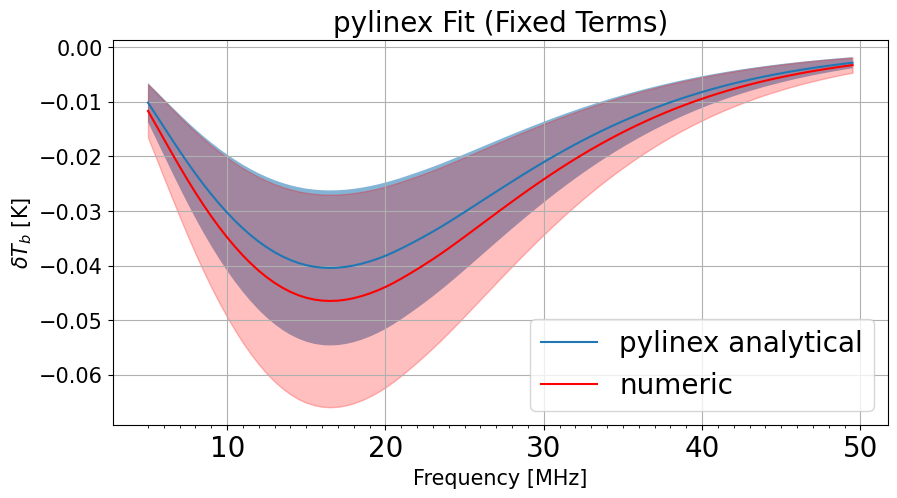

In [3]:
### This cell now plots the one sigma error of the analytical pylinex error ###
mean = rn_Fatima_simp1_vhc_fixed[11][0].subbasis_channel_mean("signal")  # values that define the mean of the fit.
error = rn_Fatima_simp1_vhc_fixed[11][0].subbasis_channel_error("signal")
mean_numeric = rn_Fatima_simp1_vhc_fixed[1]
sigma1 = rn_Fatima_simp1_vhc_fixed[2]
error_numeric = np.abs(sigma1-mean)
# This is a boiler plate plot with all the good options figured out
plt.figure(figsize=(10, 5))


plt.plot(frequencies,mean, label="pylinex analytical")
plt.plot(frequencies,mean_numeric, color = "red", label = "numeric")
plt.fill_between(frequencies, mean+error, mean-error,alpha=0.55)
plt.fill_between(frequencies, mean_numeric+error_numeric, mean_numeric-error_numeric,alpha=0.25, color="red") 
plt.xticks(ticks=np.arange(5,51,1),minor=True)
plt.xticks(size=20)
plt.xlabel("Frequency [MHz]",fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r"$\delta T_b$ [K]",fontsize=15)
plt.title(r"pylinex Fit (Fixed Terms)", fontsize=20)
plt.legend(fontsize=20)
plt.grid()

### Coding up Primordial Black Holes:
Based off a combination of Clark et al. 2018 and Koivu et al. 2026 (in prep)

$\frac{dT_{k}}{dz} = \frac{dT_{k}}{dz}|_{org} + \frac{2(1+z)^2}{3k_bH(z)}\frac{5.34\times 10^{25}\frac{g^3}{s}f_h(E,z)(\phi_{e^\pm}+\phi_\gamma)^2\rho_{c,0}\Omega_{BH,0}}{n_hM_{BH}^3(1+f_{He}+x_e)}$

where $f_h$ is the portion of energy going into heating the IGM, $\phi_{e^\pm}$ is the portion of the Hawking radiation spectrum that is electron-positron pairs, $\phi_{\gamma}$ is the portion of the spectrum that are photons, $\Omega_{BH,0}$ is the density parameter of primordial black holes today, and $M_{BH}$ is the mass of the PBHs for the model.

And for the ionization fraction:

$\frac{dx_e}{dz} = \frac{dx_e}{dz}|_{org} + \left[\frac{f_i(E,z)}{n_hE_i}+(1-C)\frac{f_\alpha(E,z)}{n_hE_{\alpha}}\right] \frac{5.34\times 10^{25}\frac{g^3}{s}(\phi_{e^\pm}+\phi_\gamma)^2\rho_{c,0}\Omega_{BH,0}(1+z)^2}{M_{BH}^3H(z)}$

In [18]:
def Tk_PBH (z_array,m_bh,obh0=omC0,omR0=omR0,omM0=omM0,omK0=omK0,omL0=omL0):
    """Creates an array evolving the IGM temperature based on adiabatic cooling, compton scattering, and dark matter sefl-annihilation. Only works for the cosmic 
    Dark Ages, as it does not include UV.
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values. Needs to be a sufficiently fine grid. 
    As of now there is some considerable numerical instabilities when your z grid is > 0.01

    m_bh = mass of the primordial black holes
    obh0 = density parameter of primordial black holes today. Defaults to beeing equal to OmC0, which implies all of dark matter is PBHs.

    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature
    Tk_function: Interpolated version of your Tk_array that acts like a function with
    redshift for its argument. Useful for future calculations.
    xe_function: Interpolation function for the fraction of free electrons
    xe_array: Array created from the x_e function."""

    num=len(z_array)
    t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    old_x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.ones((num-1,2))   # creates a blank array for use below
    z_start = z_array[-1]
    z_end = z_array[0]
    ## Some important constants
    g_i = 1/3      # fraction of energy deposited into ionization
    g_e = 1/3      # fraction of energy depostied into excitation of hydrogen and helium
    g_h = 1/3      # fraction of energy deposited into the IGM
    E_i = 13.6     # [eV] energy of ground state hydrogen
    E_e = 3.4      # [eV] energy of other states of hydrogen (took the next largest)
    C = 0.1      # efficiency of the excitation in transfering energy to ionizing the IGM. Should be between 0 to 1. 1 being maximally inefficient.
    phi_e = 0.142     # portion of the Hawking radiation spectrum that goes towards creating electron positron pairs
    phi_gamma = 0.06        # portion of the Hawking radiation spectrum that goes towards creating photons
    g2eV = 5.61e32      #[ev/gram] converts from grams to eV (need to have the critical density of the universe in units of energy, not mass for this.)

    # This defines our right hand side function
    delta_z = np.abs(z_array[1]-z_array[0])
    standard_dxe_dz = scipy.interpolate.CubicSpline(z_array,np.gradient(old_x_e(z_array))*(1/delta_z)) # standard electron fraction model based on camb
    PBH_dxe_dz = lambda z,xe:  (g_i/(n_H(z,xe)*E_i)+(1-C)*(g_e/(n_H(z,xe)*E_e)))*(5.34e25*(phi_e+phi_gamma)**2*p_crit*g2eV*obh0*(1+z)**2/(m_bh**3*H(z,omR0,omM0,omK0,omL0)))
    
    ################# We are right here in our conversion from DMD to PBH
    
    func_xe = lambda z,xe: standard_dxe_dz(z)-(1/2*scipy.special.erf(0.01*(z-900))+1/2)*annihilation_dxe_dz(z,xe)  # total rate of change of free electrons

    # Initial conditions
    xe_0 = np.array([old_x_e(z_array[-1])])    # sets our initial condition at our starting redshift (usually 1100 for dark age stuff)

    # Time span
    z_span = (z_start, z_end)

    # Solve the differential equation
    sol = solve_ivp(func_xe, z_span, xe_0, dense_output=True, method='Radau')

    # Access the solution
    z = sol.t
    xe = sol.y[0]

    xe_function=scipy.interpolate.CubicSpline(z[::-1],xe[::-1])
    x_e = xe_function
    xe_array = np.array([z,xe])
         
    g_h = lambda z: (1+2*x_e(z))/3


### Let's code up T_k
    ## The heating / cooling processes ##
    
    adiabatic = lambda zs,T:(1/(H(zs,omR0,omM0,omK0,omL0)*(1+zs)))*(2*H(zs,omR0,omM0,omK0,omL0)*T)
    compton = lambda zs,T: (1/(H(zs,omR0,omM0,omK0,omL0)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))
    dman = lambda zs,T,f_dman_e_0,g_h: (2/3)*(1/(H(zs,omR0,omM0,omK0,omL0)*kb_ev))*f_dman_e_0*g_h(zs)*1/(1+f_He+x_e(zs))*(1+zs)**2*0.3     # dark matter self-annihilation


    T0 = np.array([T_gamma(z_array[-1])])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    z0 = z_array[-1]    # defines your starting z (useful for the loop below)
    z_span = (z_start,z_end)
    func = lambda z,T: adiabatic(z,T) - compton(z,T) - dman(z,T,f_dman_e_0,g_h)

    # Solve the differential equation
    sol = solve_ivp(func, z_span, T0, dense_output=True, method='Radau')

    # Access the solution
    z = sol.t
    T = sol.y[0]

    Tk_function=scipy.interpolate.CubicSpline(z[::-1],T[::-1])  # Turns our output into a function with redshift as an argument  
    Tk_array = np.array([z,T])   
    return Tk_array, Tk_function,xe_function, xe_array

In [19]:
# testing the basic functioning of PBH_dxe_dz

g_i = 1/3      # fraction of energy deposited into ionization
g_e = 1/3      # fraction of energy depostied into excitation of hydrogen and helium
g_h = 1/3      # fraction of energy deposited into the IGM
E_i = 13.6     # [eV] energy of ground state hydrogen
E_e = 3.4      # [eV] energy of other states of hydrogen (took the next largest)
C = 0.1      # efficiency of the excitation in transfering energy to ionizing the IGM. Should be between 0 to 1. 1 being maximally inefficient.
phi_e = 0.142     # portion of the Hawking radiation spectrum that goes towards creating electron positron pairs
phi_gamma = 0.06        # portion of the Hawking radiation spectrum that goes towards creating photons
g2eV = 5.61e32      #[ev/gram] converts from grams to eV (need to have the critical density of the universe in units of energy, not mass for this.)
Obh0=omC0
m_bh = 10e16
PBH_dxe_dz = lambda z,xe:  (g_i/(n_H(z,xe)*E_i)+(1-C)*(g_e/(n_H(z,xe)*E_e)))*(5.34e25*(phi_e+phi_gamma)**2*p_crit*g2eV*Obh0*(1+z)**2/(m_bh**3*H(z,omR0,omM0,omK0,omL0)))
PBH_dxe_dz(z_array,camb_xe_interp)

array([6.09980246e-04, 5.42944568e-04, 4.85780074e-04, ...,
       3.15966369e-08, 3.15707735e-08, 3.15453872e-08])

### Best Fit to the Foreground

So the best fit method will be hugely important for the second paper on degeneracy and optimizing training sets and such, but this one could benefit from it as well and I'd like to work on that right now because it's kinda fun.

Idea 1): Use the five region model and its 15 parameters and set that equal to a specific brightness temperature at a specific frequency. This is one equation. Now do that for 14 more frequency bins and slide through all frequency bins to get a distribution of solutions per frequency. I'm intersted to see what this looks like. It should just move in a noisy pattern related to the radiometer noise. Let's find out.
-   Conclusion: Pretty sure this can't work unless your data is exactly following a synchrotron equation and we have Dark Ages signal (however small) and also noise (not so terribly small) that will cause the given temperatures to not be perfect and therefore be unsolvable in an analytical way. It has to be numerical! Let's call this idea and move on to the next.

Idea 2): Just make a really big training set that stabilizes the chi-squared (hopefully around 1.0) and trim that training set to see if it adjusts your ability to extract the model. It really might be that simple. Let's see.

Idea 3): Do you telescoping method where you build a training set and then choose the best 10% or so, but instead of taking the full parameter range of all the curves, form a covariance matrix to further constrain the parameters. Not quite sure exactly how to implement this right now but we'll figure it out if the first idea doesn't work



In [ ]:
### Idea 1 ###
## plan is to use scipy to solve an algebraic equation for our five region model.

def n_region_synchrotron_foreground(parameters,frequencies,reference_frequency=408):
    """Creates a set of equations with frequency as an input that can be plugged into scipy.optimize.fsolve to get the parameter values.
    
    Parameters
    ==============================
    parameters: List of parameters to apply to the model. The shape must be (number of regions, 3). The correct order for synchrotron is [Amplitude, spectral index, spectral curvature]
    frequencies: The array of frequencies to evaluate the model at.
    reference_frequency: The frequency that non dimensionalizes the frequency array for the synchrotron equation (in MHz). Usually its 408 MHz for anything related to Dark Ages or Cosmic Dawn.
                         (has to do with the EDGES experiment and the trough they detected, so it certainly is a bit arbitrary.)
    
    Returns
    ==============================
    temperature_array: array of temperatures associated with the input frequencies"""
    temperature_array = np.zeros(len(frequencies))
    for i,f in enumerate(frequencies):
        element = 0
        for n in range(len(parameters)):          # loops through all the regions, which is defined by the user simply based on the shape of the parameter array (see the documentation above).
            element += parameters[n][0]*(f/reference_frequency)**(parameters[n][1]+parameters[n][2]*np.log(f/reference_frequency))
        temperature_array[i] = element

    return temperature_array
            

In [ ]:
sol = fsolve(n_region_synchrotron_foreground,[[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015],[10,-2.5,-0.015]])

Region 1: 2458
Region 2: 2457
Region 3: 2458
Region 4: 2457
Region 5: 2458


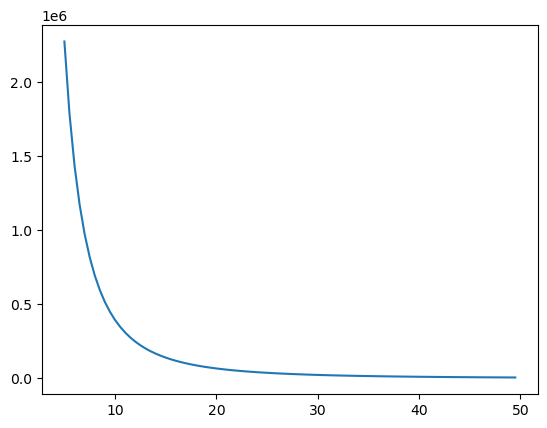

In [ ]:
# let's test out the function:

parameters = np.array([[1.59202418e+01,-2.65279830e+00,-1.37293590e-02],[1.66130589e+01,-2.69062579e+00,-1.47582387e-02],[1.89769800e+01,-2.68235795e+00,-1.34495335e-02],\
                       [2.42115565e+01,-2.66682587e+00,-1.20169084e-02],[5.22431891e+01,-2.65055339e+00,-2.42275191e-02]])      # five region parameter example (best fit to base ULSA)

temperature_array_test=n_region_synchrotron_foreground(parameters,frequencies)      # testing out the above function using the ULSA best fit parameters

sky_map = master_foreground_array[0]  # sets the sky map as the ULSA 32 bit map with the dead zone removed and CMB removed
reference_frequency = 25    # Reference frequency to determine the regions at [MHz]
n_regions = 5
patch=perses.models.PatchyForegroundModel(frequencies,sky_map[reference_frequency-1],n_regions)
region_indices=patch.foreground_pixel_indices_by_region_dictionary
print(f"Region 1: {len(region_indices[0])}")
print(f"Region 2: {len(region_indices[1])}")
print(f"Region 3: {len(region_indices[2])}")
print(f"Region 4: {len(region_indices[3])}")
print(f"Region 5: {len(region_indices[4])}")

### The size of each region in pixels is close enough to equal ###

plt.plot(frequencies,temperature_array_test/5) # divided by 5 because the convention of the patchy sky model ensures that the regions are equally sized over the full sky.